In [845]:
import re
import pytz
import talib
import pickle
import requests
import pandas as pd
import numpy as np
import robin_stocks as robinhood
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib as mpl
import seaborn as sns
from scipy import optimize
from bs4 import BeautifulSoup
from selenium import webdriver
from datetime import datetime, timedelta
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.expected_conditions import presence_of_element_located

sns.set()
mpl.style.use('seaborn')

# scrape sleek options filter
# filter out trades for time alert posted on, average return on first day of prev alerts for that ticker
# buy filtered set of options
# save set of currently bought options


# poll bought options
# when peak profit surpasses average peak profit on first day +/i some threshold, sell

In [980]:
chrome_options = Options()
chrome_options.add_argument("--headless") 
driver = webdriver.Chrome('/Users/sibtain/Projects/sumo-ui-test/BentoUITests/node_modules/webdriver-manager/selenium/chromedriver_2.42', options=chrome_options)
timezone = pytz.timezone('EST')
SELECTORS = {
    'email_input': '#rowUserName input',
    'pass_input': '#rowPassword input',
    'login_btn': '#MainContent_btnLogin',
    'logout_btn': 'a[href="Login.aspx?lout=Y"]',
    'data_table': '#MainContent_lbl_data_grid table'
}

def wait_until_exists(selector, max_wait = 5):
    try:
        WebDriverWait(driver, max_wait).until(
            presence_of_element_located((By.CSS_SELECTOR, selector))
        )
    except TimeoutException:
        return False

def sign_in():
    driver.get('https://sleekoptions.com/Login.aspx')
    email_input = driver.find_element_by_css_selector(SELECTORS['email_input'])
    pass_input = driver.find_element_by_css_selector(SELECTORS['pass_input'])
    login_btn = driver.find_element_by_css_selector(SELECTORS['login_btn'])
    email_input.send_keys('Hyskos70@gmail.com')
    pass_input.send_keys('<PASSWORD>')
    login_btn.click()
    signed_in = wait_until_exists(SELECTORS['logout_btn'])
    
    if not signed_in:
        ensure_logged_in()
    else:
        save_cookies()
        
def ensure_logged_in():
    if "sleekoptions" not in driver.current_url:
        driver.get('https://sleekoptions.com/home.aspx')
    
    logged_in = False
    try:
        logout_btn = driver.find_element_by_css_selector(SELECTORS['logout_btn'])
        logged_in = False
    except NoSuchElementException:
        sign_in()
        
    return logged_in

def parse_number_str(number_str):
    numbers = re.findall('\d*\.?\d+',number_str)
    return float(numbers[0] if numbers else 'inf')

def save_cookies():
    pickle.dump(driver.get_cookies(), open("cookies.pkl", "wb"))
    
def load_cookies():
    try:
        cookies = pickle.load(open("cookies.pkl", "rb"))
        for cookie in cookies:
            driver.add_cookie(cookie)
    except:
        return False
    
    return True

column_headers = ['date_posted', 'symbol', 'type', 'exp', 'strike', 'algo', 'price_when_posted', 'peak_profit', 'time_to_peak']
def scrape_sleek_filter(url):
    ensure_logged_in()
    driver.get(url)

    options = list()
    for tr in driver.find_elements_by_css_selector('table tr.data_row'):
        option = dict()
        for idx, td in enumerate(tr.find_elements_by_css_selector('td')):
            value = None
            if idx <= 1 or idx >= 9:
                continue
            if idx == 2: # date posted
                option['date_posted'] = timezone.localize(datetime.strptime(td.text[:-5].strip(), "%m/%d/%y %I:%M %p"))
            elif idx == 3: # symbol
                option['symbol'] = td.text.strip()
            elif idx == 4: # option info: exp, strike, type, algo
                option['type'] = "Put" if "Puts" in td.text else "Call"
                rest = td.text.split(option['type'])
                exp_and_strike = rest[0].split(" ")
                option['exp'] = timezone.localize(datetime.strptime(exp_and_strike[0] + "-2020", "%b-%d-%Y"))
                option['strike'] = parse_number_str(exp_and_strike[1])
                algo_type = rest[1].split("\n")
                option['algo'] = algo_type[1].strip()
            elif 5 <= idx <= 7:
                option[column_headers[idx + 1]] = parse_number_str(td.text)
            elif idx == 8 and td.text.strip():
                time_unit = "m" if "Mins" in td.text else "d"
                time_to_peak = parse_number_str(td.text)
                option['time_to_peak'] = option['date_posted'] + (timedelta(minutes=time_to_peak) if time_unit is "m" else timedelta(days=time_to_peak))
        
        options.append(option)
        
    driver.close()
    
    df = pd.DataFrame(options, columns=column_headers)
    return df

# sleek_df = scrape_sleek_filter('https://sleekoptions.com/goodsetups.aspx?at=RA&adate=today')
sleek_df = scrape_sleek_filter('https://sleekoptions.com/goodsetups.aspx?qsid=6EAFDBD8-0A44-4947-AF61-54668D07E311')

In [834]:
# clean df

sleek_df_norm = sleek_df.copy()
sleek_df_norm.tail()

,date_posted,symbol,type,exp,strike,algo,price_when_posted,peak_profit,time_to_peak
556,2020-07-15 09:35:00-05:00,FB,Put,2020-07-17 00:00:00-05:00,235.0,{HighRisk} Dip 40% for 23C9F Jul-17 235,1.50,2.63,2020-07-15 21:02:00-05:00
557,2020-07-15 09:35:00-05:00,UAL,Put,2020-07-17 00:00:00-05:00,31.0,{HighRisk} Dip 70% for 64D80 Jul-17 31,0.30,0.43,2020-07-15 10:17:00-05:00
558,2020-07-15 09:34:00-05:00,TWTR,Put,2020-07-17 00:00:00-05:00,33.0,{HighRisk} Dip 70% for 61B58 Jul-17 33,0.14,1.20,2020-07-16 09:34:00-05:00
559,2020-07-15 09:34:00-05:00,TWTR,Put,2020-07-17 00:00:00-05:00,33.0,{HighRisk} Dip 40% for 61B58 Jul-17 33,0.14,1.20,2020-07-16 09:34:00-05:00
560,2020-07-15 09:34:00-05:00,PFE,Put,2020-07-17 00:00:00-05:00,35.0,{HighRisk} Dip 70% for 0371A Jul-17 35,0.15,0.18,2020-07-15 09:42:00-05:00


In [384]:
# only consider options posted today

def filter_df_by_date(df, from_date, to_date, key = 'date'):
    from_date = timezone.localize(datetime.strptime(from_date, "%Y-%m-%d"))
    to_date = timezone.localize(datetime.strptime(to_date, "%Y-%m-%d"))
    idx = (df[key] > from_date) & (df[key] <= to_date)
    return df[idx]

filter_df_by_date(norm_df, '2020-07-20', '2020-07-21', 'date_posted')
# filter for time alert posted on (do this later), average return on first day of prev alerts for that ticker, RSI, Bollinger, MCAD
# use 5m option prices from RH to calculate sell point based on: profit >= ave profit +/- some threshold, or profit <= 40%

,date_posted,symbol,type,exp,strike,algo,price_when_posted,peak_profit,time_to_peak
54,2020-07-20 15:45:00-04:00,BA,Call,2020-07-31 00:00:00-04:00,175.0,{HighRisk} Dip 40% for 8800E Jul-31 175,8.04,13.50,2020-07-21 15:45:00-04:00
55,2020-07-20 15:45:00-04:00,TWTR,Put,2020-07-31 00:00:00-04:00,35.0,{HighRisk} Dip 40% for 6F55F Jul-31 35,1.42,1.19,16.55
56,2020-07-20 15:24:00-04:00,FB,Put,2020-07-24 00:00:00-04:00,237.5,{HighRisk} Dip 70% for 1E036 Jul-24 237.5,1.77,3.16,2020-07-21 15:24:00-04:00
57,2020-07-20 14:49:00-04:00,SQ,Call,2020-08-07 00:00:00-04:00,130.0,Primary,7.70,8.95,2020-07-21 14:49:00-04:00
58,2020-07-20 14:48:00-04:00,BA,Call,2020-08-07 00:00:00-04:00,177.5,Primary,11.05,14.00,2020-07-21 14:48:00-04:00
...,...,...,...,...,...,...,...,...,...
111,2020-07-20 09:34:00-04:00,TWTR,Put,2020-07-24 00:00:00-04:00,34.0,{HighRisk} Dip 40% for C5838 Jul-24 34,1.10,0.76,31.36
112,2020-07-20 09:33:00-04:00,SQ,Put,2020-07-24 00:00:00-04:00,120.0,{HighRisk} Dip 40% for BF0B1 Jul-24 120,2.99,3.10,2020-07-20 09:35:00-04:00
113,2020-07-20 09:33:00-04:00,GLD,Put,2020-07-24 00:00:00-04:00,168.5,{HighRisk} Dip 70% for 8441D Jul-24 168.5,0.35,0.78,2020-07-21 09:33:00-04:00
114,2020-07-20 09:32:00-04:00,PFE,Put,2020-07-24 00:00:00-04:00,35.0,{HighRisk} Dip 70% for B3BAF Jul-24 35,0.08,0.09,2020-07-20 09:37:00-04:00


In [983]:
robinhood.login('sibtain462@gmail.com','<PASSWORD>')

def fetch_options_prices(symbol, exp, strike, option_type, interval = '5minute', span = 'week'):
    symbol_name = robinhood.get_name_by_symbol(symbol)
    bounds = 'regular' # available options are 'regular', 'trading', and 'extended'.
    info = None
    df = pd.DataFrame(robinhood.get_option_historicals(symbol, exp, strike, option_type, interval, span, bounds, info))
    return clean_rh_data(df)

def clean_rh_data(df):
    df_copy = df.copy()
    df_copy.dropna(inplace=True)
    if len(df_copy) < 1:
        return df_copy
    
    df_copy["begins_at"] = df["begins_at"].astype('datetime64').dt.tz_localize('EST')
    df_copy['date'] = (df_copy['begins_at'] - np.timedelta64(4, 'h'))
    df_copy['low'] = df_copy['low_price'].astype(float)
    df_copy['high'] = df_copy['high_price'].astype(float)
    df_copy['open'] = df_copy['open_price'].astype(float)
    df_copy['close'] = df_copy['close_price'].astype(float)
    df_copy.drop(['volume', 'session', 'interpolated', 'begins_at', 'open_price', 'low_price', 'high_price', 'close_price'], 1, inplace=True)
    return df_copy

# dis_put_24_115 = get_options_prices('DIS', '2020-07-24', 115, 'put')
# dis_put_24_118 = get_options_prices('DIS', '2020-07-24', 118, 'put')
# fb_call_24 = get_options_prices('FB', '2020-08-07', 245, 'call')

ERROR: There was an issue loading pickle file. Authentication may be expired - logging in normally.
Enter Robinhood code for validation: 225303


In [981]:
def create_plot():
    loc = plticker.MultipleLocator(base=5.0)
    fig, ax = plt.subplots(figsize=(20,4))
    ax.minorticks_off()
    ax.xaxis.set_major_locator(loc)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
    )
    return fig, ax

def plot_rh(df):
    df_copy = df.copy()
    fig, ax = create_plot()
    df_copy['formatted_date'] = df_copy['date'].dt.strftime('%D %H:%M %p')
    chart = sns.lineplot(x="formatted_date", y="close", data=df_copy)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
    )
    plt.title('Close Price')
    plt.show()

def plot_rh_rsi(df): 
    df_copy = df.copy()
    fig, ax = create_plot()
    df_copy['rsi'] = talib.RSI(df_copy['close'], timeperiod=5)
    df_copy['formatted_date'] = df_copy['date'].dt.strftime('%D %H:%M %p')
    chart = sns.lineplot(x="formatted_date", y="rsi", data=df_copy)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
    )
    plt.title('Close RSI')
    plt.show()
    
def plot_rh_momentum(df):
    df_copy = df.copy()
    fig, ax = create_plot()
    df_copy['momentum'] = talib.MOM(df_copy['close'], timeperiod=5)
    df_copy['formatted_date'] = df_copy['date'].dt.strftime('%D %H:%M %p')
    chart = sns.lineplot(x="formatted_date", y="momentum", data=df_copy)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
    )
    plt.title('Close Momentum')
    plt.show()
    
def plot_rh_bollinger(df):
    df_copy = df.copy()
    fig, ax = create_plot()
    upper, middle, lower = talib.BBANDS(df_copy['close'], matype=talib.MA_Type.T3)
    df_copy['formatted_date'] = df_copy['date'].dt.strftime('%D %H:%M %p')
    x = df_copy['formatted_date']
    plt.plot(x, df_copy.close, x, upper, x, lower)
    plt.title('Close Bollinger Bands')
    plt.show()
    
def plot_rh_indicators_together(df):
    df_copy = df.copy()
    fig, ax = create_plot()
    upper, middle, lower = talib.BBANDS(df_copy['close'], matype=talib.MA_Type.T3)
    df_copy['momentum'] = talib.MOM(df_copy['close'], timeperiod=2)
    df_copy['formatted_date'] = df_copy['date'].dt.strftime('%D %H:%M %p')
    x = df_copy['formatted_date']
    plt.plot(x, df_copy.close, '-', label='Close')
    plt.plot(x, df_copy['momentum'], '-', label='Momentum')
    plt.plot(x, upper, '.', label='Upper BB')
    plt.plot(x, lower, '.', label='Lower BB')
    plt.title('Close Price Indicators')
    plt.legend()
    plt.show()

def plot_rh_indicators_individually(df):
    plot_rh_rsi(df)
    plot_rh_momentum(df)
    plot_rh_bollinger(df)

# plot_rh_indicators_individually(fb_call_24)
# plot_rh_indicators_together(fb_call_24)

In [731]:
# options_data = dict()

def get_options_prices(symbol, exp, strike, option_type, interval = '5minute', span = 'week', refresh = False):
    if symbol not in options_data:
        options_data[symbol] = dict()

    if exp not in options_data[symbol]:
        options_data[symbol][exp] = dict()
    
    if strike not in options_data[symbol][exp]:
        options_data[symbol][exp][strike] = dict()
    
    if refresh or (option_type not in options_data[symbol][exp][strike]):
        options_data[symbol][exp][strike][option_type] = fetch_options_prices(symbol, exp, strike, option_type, interval, span)
        
    return options_data[symbol][exp][strike][option_type]
    
# get_options_prices('SPOT', '2020-07-24', 277.5, 'put')
# get_options_prices('LULU', '2020-08-07', 322.5, 'put')

In [427]:
sleek_df_norm.head()

,date_posted,symbol,type,exp,strike,algo,price_when_posted,peak_profit,time_to_peak
0,2020-07-22 15:38:00-04:00,FB,Put,2020-08-07 00:00:00-04:00,237.5,Primary,9.52,9.52,0
1,2020-07-22 15:02:00-04:00,NKE,Put,2020-07-31 00:00:00-04:00,98.0,Primary,1.72,1.72,0
2,2020-07-22 14:38:00-04:00,LUV,Call,2020-07-24 00:00:00-04:00,34.0,{HighRisk} Dip 70% for 1C081 Jul-24 34,0.48,0.53,2020-07-22 15:39:00-04:00
3,2020-07-22 14:31:00-04:00,MRNA,Put,2020-08-07 00:00:00-04:00,80.0,{HighRisk} Dip 40% for 0B622 Aug-07 80,5.80,5.96,2020-07-22 15:10:00-04:00
4,2020-07-22 14:23:00-04:00,MRNA,Call,2020-07-31 00:00:00-04:00,83.0,Primary,4.71,5.95,2020-07-22 14:38:00-04:00


In [979]:
BOLLINGER_THRESHOLD = 0.2
def filter_sleek_option(df, date_posted):
    
    # filter beginning of day
    idx = (beginning_of_date_posted <= df['date']) & (df['date'] <= date_posted)
    df_copy = df[idx].copy()
    
    if len(df_copy) < 1:
        return df_copy
    
    # bollinger filter
    upper, middle, lower = talib.BBANDS(df_copy['close'], matype=talib.MA_Type.T3)
    df_copy['upper'] = upper
    df_copy['lower'] = lower
    df_copy = df_copy[np.absolute(df_copy['close'] - BOLLINGER_THRESHOLD) <= lower]
    
    return df_copy


# CLOSE_STD_BUY_LOWER_BB_MULTIPLIER = 5
# DIFF_IN_BUY_PRICE_STD_MULTIPLIER = 0.62

# # SELLING PARAMS
# SELL_PROFIT_THRESHOLD  = 1.2
# SELL_LOSS_THRESHOLD = 0.7
# CLOSE_STD_SELL_UPPER_BB_MULTIPLIER = 1.5
# RSI_FILTER_THRESHOLD_UPPER = 70
# RSI_FILTER_THRESHOLD_LOWER = 20

# BUYING PARAMS
CLOSE_STD_BUY_LOWER_BB_MULTIPLIER = 0.25
DIFF_IN_BUY_PRICE_STD_MULTIPLIER = 1

# SELLING PARAMS
SELL_PROFIT_THRESHOLD  = 1.2
SELL_LOSS_THRESHOLD = 0.7
CLOSE_STD_SELL_UPPER_BB_MULTIPLIER = 1.5
RSI_FILTER_THRESHOLD_UPPER = 70
RSI_FILTER_THRESHOLD_LOWER = 20


def get_profit(sleek_option, CLOSE_STD_BUY_LOWER_BB_MULTIPLIER, DIFF_IN_BUY_PRICE_STD_MULTIPLIER, SELL_PROFIT_THRESHOLD, SELL_LOSS_THRESHOLD, CLOSE_STD_SELL_UPPER_BB_MULTIPLIER, RSI_FILTER_THRESHOLD_UPPER):
    # get associated options prices from rh
    rh_df = get_options_prices(sleek_option['symbol'], sleek_option['exp'].strftime('%Y-%m-%d'), sleek_option['strike'], sleek_option['type'].lower())
    
    if len(rh_df) < 1:
        return [None] * 4
    
    date_posted = sleek_option['date_posted']
    beginning_of_date_posted = sleek_option['date_posted'].replace(hour=0, minute=0)
    end_of_date_posted = sleek_option['date_posted'].replace(hour=23, minute=59)
    
    before_idx = (beginning_of_date_posted <= rh_df['date']) & (rh_df['date'] < date_posted)
    after_idx = (date_posted < rh_df['date']) & (rh_df['date'] < end_of_date_posted)
    day_of_idx = before_idx | after_idx
    rh_df = rh_df.dropna(subset=['close'])
    rh_df_before_date_posted = rh_df[before_idx].copy()
    rh_df_after_date_posted = rh_df[after_idx].copy()
    rh_df_day_of_posted = rh_df[day_of_idx]
    
    if len(rh_df_before_date_posted) < 1:
        return [None] * 4
    
    close_std_buy = np.std(rh_df_before_date_posted['close'])
    upper_bb_buy, middle_bb_buy, lower_bb_buy = talib.BBANDS(rh_df_before_date_posted['close'], matype=talib.MA_Type.T3)
    rh_df_before_date_posted['upper'] = upper_bb_buy
    rh_df_before_date_posted['lower'] = lower_bb_buy
    bollinger_filter_buy = rh_df_before_date_posted['close'] <= (rh_df_before_date_posted['lower'] + close_std_buy*CLOSE_STD_BUY_LOWER_BB_MULTIPLIER)
    
    last_good_buy_df = rh_df_before_date_posted[bollinger_filter_buy].head(1)
    buy_df = rh_df_after_date_posted.head(1)
    should_buy = not buy_df.empty and not last_good_buy_df.empty
    diff_in_buy_price = float('inf')
    
    if should_buy:
        buy_price = buy_df['close'].tolist()[0]
        buy_date = buy_df['date'].tolist()[0]
        last_good_buy_price = last_good_buy_df['close'].tolist()[0]
        last_good_buy_date = last_good_buy_df['date'].tolist()[0]
        diff_in_buy_price = last_good_buy_price - buy_price
    
    if not should_buy or not buy_price <= last_good_buy_price or abs(diff_in_buy_price) > DIFF_IN_BUY_PRICE_STD_MULTIPLIER*close_std_buy:
        return [None] * 4
    
    rh_df_after_date_posted = rh_df_after_date_posted[rh_df_after_date_posted['date'] > buy_date]
    # strategy 1 -> sell when profit is >= 120% or loss is >= 40%
    profit_threshold_filter = rh_df_after_date_posted['close'] >= SELL_PROFIT_THRESHOLD * buy_price
    sell_profit_df = rh_df_after_date_posted[profit_threshold_filter]
    sell_loss_df = rh_df_after_date_posted[rh_df_after_date_posted['close'] <= SELL_LOSS_THRESHOLD * buy_price]
    
    # strategy 2 -> sell when price hits top bollinger band & RSI > 60
    close_std = np.std(rh_df_day_of_posted['close'])
    upper, middle, lower = talib.BBANDS(rh_df_day_of_posted['close'], matype=talib.MA_Type.T3)
    rh_df_after_date_posted['rsi'] = talib.RSI(rh_df_day_of_posted['close'], timeperiod=5)
    rh_df_after_date_posted['upper'] = upper
    
    rsi_filter = rh_df_after_date_posted['rsi'] >= RSI_FILTER_THRESHOLD_UPPER
    bollinger_filter = rh_df_after_date_posted['close'] >= (rh_df_after_date_posted['upper'] - close_std*CLOSE_STD_SELL_UPPER_BB_MULTIPLIER)
    sell_profit_df = rh_df_after_date_posted[(bollinger_filter | rsi_filter) & profit_threshold_filter]
    
    sell_df = sell_profit_df if not sell_profit_df.empty else sell_loss_df
    sell_df = sell_df if not sell_df.empty else rh_df_day_of_posted.tail(1)
    can_sell = not sell_df.empty
    sell_price = sell_df['close'].tolist()[0] if can_sell else None
    sell_date = sell_df['date'].tolist()[0] if can_sell else None
    
    ideal_sell_df = rh_df_after_date_posted[rh_df_after_date_posted['close'] == rh_df_after_date_posted['close'].max()]
    ideal_sell_price = ideal_sell_df['close'].tolist()[0]
    ideal_sell_date = ideal_sell_df['date'].tolist()[0]
    
    return buy_price, sell_price, buy_date, sell_date
    
    
def simulate_sleek_trades(params):
    a1, a2, a3, a4, a5, a6 = params
    print('-- PARAMS --', a1, a2, a3, a4, a5, a6)
    sleek_df_copy = filter_df_by_date(sleek_df_norm.copy(), '2020-07-18', '2020-07-31', key='date_posted')
    # filter this based on prev day close of SPY
    results = []
    for idx, sleek_option in sleek_df_copy.iterrows():
        buy_price, sell_price, buy_date, sell_date = get_profit(sleek_option, a1, a2, a3, a4, a5, a6)
        if buy_price is not None:
            results.append({
                'index': idx,
                'buy_price': buy_price,
                'sell_price': sell_price,
                'buy_date': buy_date,
                'sell_date': sell_date,
                'profit': sell_price - buy_price if sell_price is not None else -1 * buy_price
            })

    results_df = pd.DataFrame(results, columns=['index', 'buy_price', 'sell_price', 'buy_date', 'sell_date', 'profit'])
    results_df = results_df.set_index('index')
    sleek_df_copy['profit'] = results_df['profit']
    sleek_df_copy['sell_price'] = results_df['sell_price']
    sleek_df_copy['buy_price'] = results_df['buy_price']
    sleek_df_copy['sell_date'] = results_df['sell_date']
    sleek_df_copy['buy_date'] = results_df['buy_date']
    sleek_df_copy = sleek_df_copy.dropna(subset=['buy_price'])
#     print(sleek_df_copy.sort_values(by=['profit'], ascending=False))
    profit = np.sum(sleek_df_copy['profit'])
    print('-- PROFIT -- ', profit)

    return -1 * profit

# params = (CLOSE_STD_BUY_LOWER_BB_MULTIPLIER, DIFF_IN_BUY_PRICE_STD_MULTIPLIER, SELL_PROFIT_THRESHOLD, SELL_LOSS_THRESHOLD, CLOSE_STD_SELL_UPPER_BB_MULTIPLIER, RSI_FILTER_THRESHOLD_UPPER)
# params = (5.142575445816187, 0.5750946502057621, 1.3158847736625532, 0.7040809327846363, 1.502263374485597, 69.63751714677639)
params = (2.2706892138946584, 2.223621357162094, 1.2681647642727258, 1.7, 1.4999770560530399, 70.1228538181861)
bounds = ((0.01, 15), (0.01, 10), (1, 2), (0.01, 1), (0, 15), (50, 100))
simulate_sleek_trades(params)

-- PARAMS -- 2.2706892138946584 2.223621357162094 1.2681647642727258 1.7 1.4999770560530399 70.1228538181861
-- PROFIT --  5.2700000000000005


-5.2700000000000005

In [976]:
# result = optimize.minimize(simulate_sleek_trades, params, bounds=bounds)
# result = optimize.brute(simulate_sleek_trades, bounds)
result = optimize.minimize(simulate_sleek_trades, params, bounds=bounds, method='COBYLA', tol=1e-10)

-- PARAMS -- 2.2706892138946584 1.0170721662943942 1.0798500496275383 1.7 1.4999770560176846 70.12285381822146


/usr/local/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


-- PROFIT --  1.8800000000000008
-- PARAMS -- 3.2706892138946584 1.0170721662943942 1.0798500496275383 1.7 1.4999770560176846 70.12285381822146
-- PROFIT --  1.8800000000000008
-- PARAMS -- 2.2706892138946584 2.017072166294394 1.0798500496275383 1.7 1.4999770560176846 70.12285381822146
-- PROFIT --  2.8999999999999995
-- PARAMS -- 2.2706892138946584 2.017072166294394 2.079850049627538 1.7 1.4999770560176846 70.12285381822146
-- PROFIT --  0.32000000000000006
-- PARAMS -- 2.2706892138946584 2.017072166294394 1.0798500496275383 2.7 1.4999770560176846 70.12285381822146
-- PROFIT --  2.8999999999999995
-- PARAMS -- 2.2706892138946584 2.017072166294394 1.0798500496275383 1.7 2.4999770560176846 70.12285381822146
-- PROFIT --  2.8999999999999995
-- PARAMS -- 2.2706892138946584 2.017072166294394 1.0798500496275383 1.7 1.4999770560176846 71.12285381822146
-- PROFIT --  2.8999999999999995
-- PARAMS -- 2.2706892138946584 2.384731055665483 0.14988932945360678 1.7 1.4999770560176846 70.122853818221

-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706892138946584 2.223621357162094 1.2681647642727258 1.7 1.499982450814294 70.12284842342486
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706903411867145 2.2236215797082046 1.268163420412253 1.7000004491610112 1.4999774496914524 70.12285421189523
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706900735691007 2.2236214112609005 1.2681645980435479 1.6999990839732473 1.4999760487255651 70.12285281092934
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706892884069014 2.2236196215926567 1.2681645013457228 1.6999993800640538 1.4999773447859954 70.12285410698976
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.270687940081797 2.2236214890972135 1.2681634474250605 1.6999997430219338 1.4999767414964407 70.12285350370021
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706892138946584 2.223620984362816 1.2681647471897366 1.7000007325929767 1.4999767143079379 70.12285347651171
-- PROFIT --  5.2700000000000005
-- PARAMS -- 2.2706892138946584 2

In [903]:
len(((0, 15), (0, 10), (1, 2), (0, 1), (0, 15), (50, 100)))
len((CLOSE_STD_BUY_LOWER_BB_MULTIPLIER, DIFF_IN_BUY_PRICE_STD_MULTIPLIER, SELL_PROFIT_THRESHOLD, SELL_LOSS_THRESHOLD, CLOSE_STD_SELL_UPPER_BB_MULTIPLIER, RSI_FILTER_THRESHOLD_UPPER, RSI_FILTER_THRESHOLD_LOWER))

7

In [ ]:
# receives 5m tick for option
def receive_tick(option):
    

In [ ]:
plot_rh_indicators_individually(filter_df_by_date(get_options_prices('AAPL', '2021-01-15', 375, 'call', interval='day', span='year'), '2020-05-17', '2020-07-25', 'date'))
plot_rh_indicators_individually(filter_df_by_date(get_options_prices('SPY', '2020-07-31', 325, 'call', interval='day', span='year', refresh=True), '2020-05-17', '2020-08-01', 'date'))

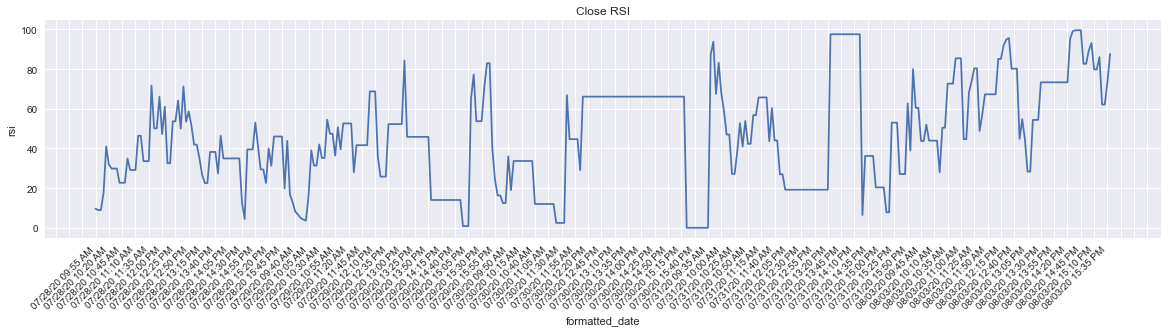

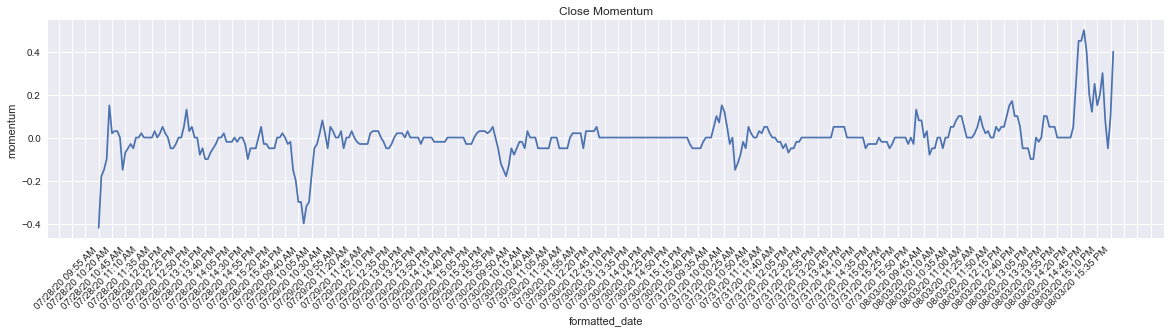

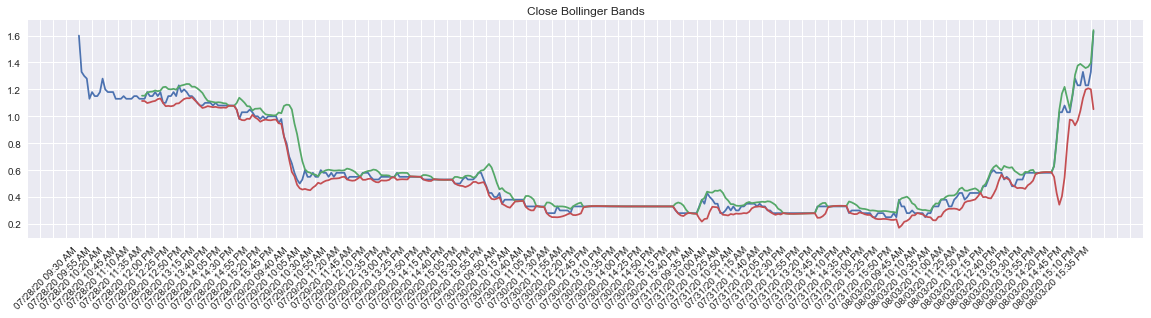

In [986]:
plot_rh_indicators_individually(filter_df_by_date(get_options_prices('NKLA', '2020-08-07', 40, 'call', interval='5minute', span='week', refresh=True), '2020-07-20', '2020-08-07', 'date'))

symbol_name:  SNAP Snap


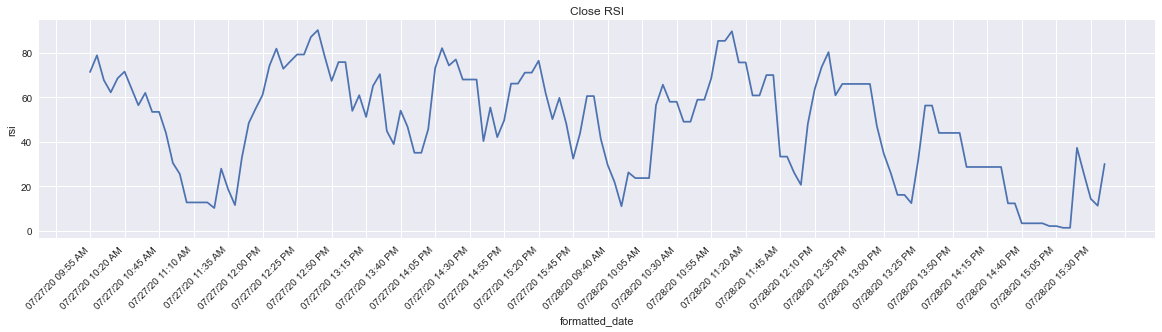

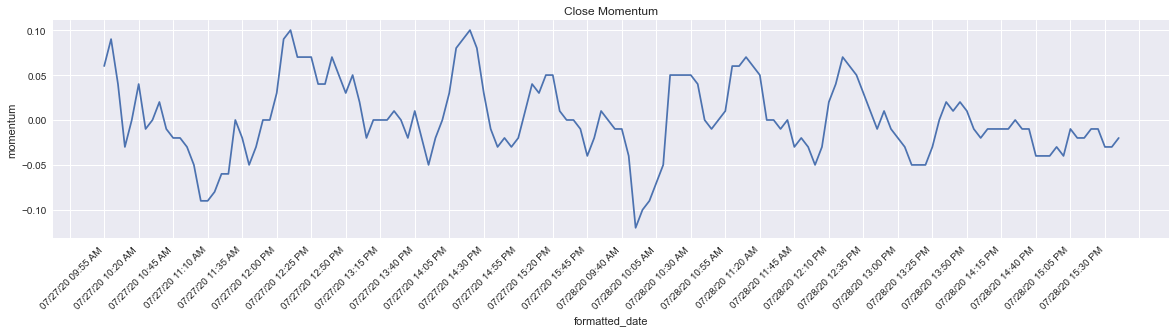

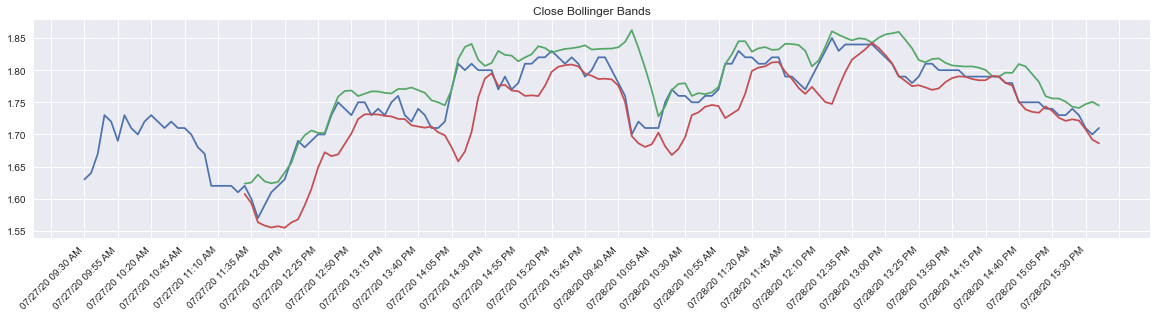

In [792]:
plot_rh_indicators_individually(filter_df_by_date(get_options_prices('SNAP', '2021-01-15', 27, 'call', interval='5minute', span='week', refresh=True), '2020-07-26', '2020-08-01', 'date'))

In [988]:
x = [3, 2, 1]
x = sorted(x)
x

[1, 2, 3]

In [989]:
-x[0]

-1